# IRIS - Connection I
---
![Concatenate Layer](https://github.com/DrKAI/image/blob/main/Concatenate%20Layer.png?raw=true)

In [2]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from sklearn.datasets import load_iris

## 데이터 불러오기

- iris.feature_names를 이용하여 판다스 데이터 프레임 만들기!

In [3]:
iris = load_iris()

x = iris.data
y = iris.target

In [4]:
df_x = pd.DataFrame(x, columns=iris.feature_names) # 우리 목적이 length끼리 묶고, width끼리 데이터를 묶으려면 pd df로 접근하는 게 편함... 그전엔 np array엿음
df_x.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


## train set, test set 구분하기

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
train_x, test_x, train_y, test_y = train_test_split(df_x, y, test_size=0.2, random_state=2023)

In [7]:
train_x.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,120.000000,120.000000,120.000000,120.000000
mean,5.847500,3.052500,3.828333,1.236667
std,0.812607,0.422072,1.740240,0.767834
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.450000,1.400000
75%,6.400000,3.325000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [8]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((120, 4), (120,), (30, 4), (30,))

## **length끼리, width끼리**

In [9]:
print(df_x.columns)

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')


In [10]:
tr_x_l = train_x.loc[:, ['sepal length (cm)', 'petal length (cm)'] ] # 콤마 기준 앞이 행에 대한 조건(:), 뒤가 열에 대한 조건(['sepal length (cm)', 'petal length (cm)'] )
tr_x_w = train_x.loc[:, ['sepal width (cm)', 'petal width (cm)'] ]

In [11]:
tr_x_l.shape, tr_x_w.shape

((120, 2), (120, 2))

In [12]:
tr_x_l.head()

,sepal length (cm),petal length (cm)
9,4.9,1.5
38,4.4,1.3
18,5.7,1.7
119,6.0,5.0
98,5.1,3.0


In [13]:
tr_x_w.head()

,sepal width (cm),petal width (cm)
9,3.1,0.1
38,3.0,0.2
18,3.8,0.3
119,2.2,1.5
98,2.5,1.1


In [14]:
train_x_length, train_x_width = np.array(tr_x_l), np.array(tr_x_w)

In [15]:
train_x_length.shape, train_x_width.shape

((120, 2), (120, 2))

In [16]:
te_x_l = test_x.loc[:, ['sepal length (cm)', 'petal length (cm)'] ]
te_x_w = test_x.loc[:, ['sepal width (cm)', 'petal width (cm)'] ]

## One-hot Encoding

In [17]:
from tensorflow.keras.utils import to_categorical

In [18]:
class_n = len(np.unique(train_y))

In [19]:
train_y = to_categorical(train_y, class_n)
test_y = to_categorical(test_y, class_n)


In [20]:
train_y.shape

(120, 3)

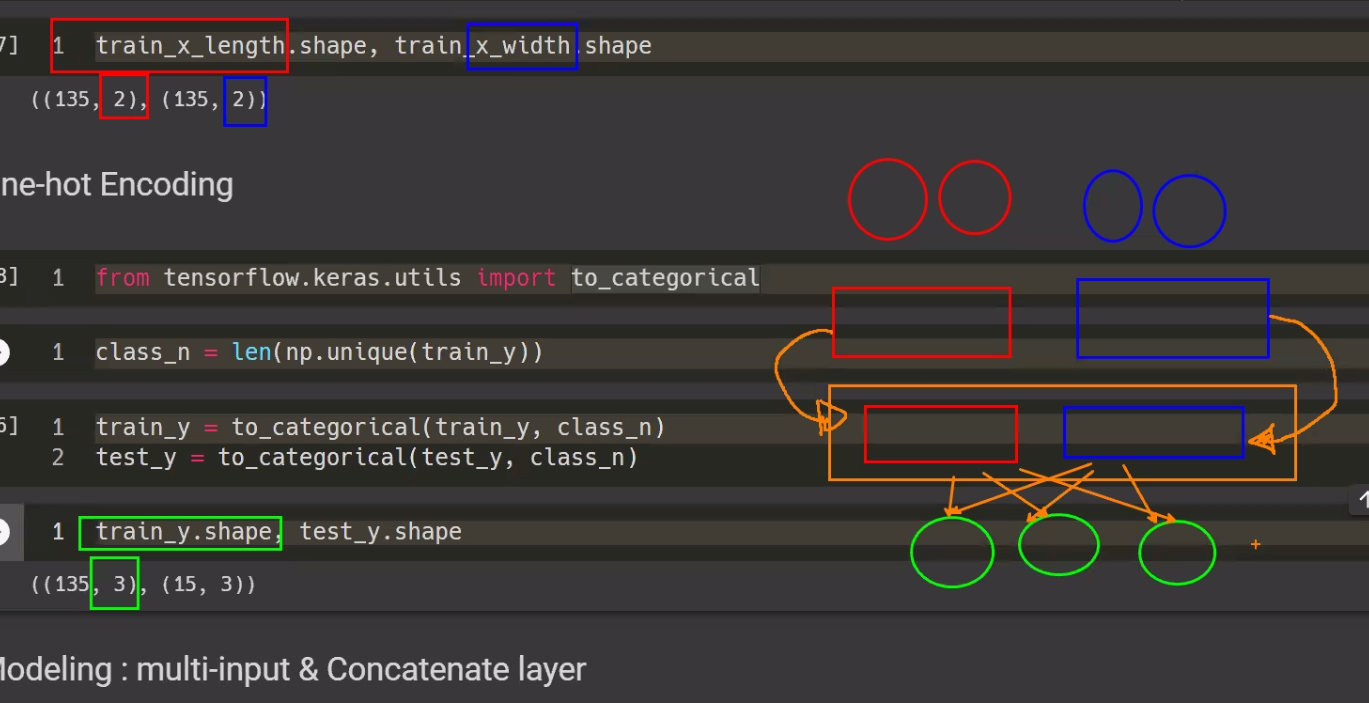

## Modeling : multi-input & Concatenate layer

In [21]:
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.activations import relu, softmax

from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [22]:
## Function API : 지금부터는 Sequential API 불가능!
# 1. 세션 클리어
clear_session()

# 2. 레이어 사슬처럼 엮기 : input 2개!
il_l = Input( shape=(2,), name='inputLength' ) # length끼리 엮을 것
hl_l = Dense(2, activation='relu', name = 'hiddenLength')(il_l)

il_w = Input( shape=(2,), name='inputWidth' ) # width 끼리 엮을 것
hl_w = Dense(2, activation='relu', name='hiddenWidth')(il_w)

cl = Concatenate()([hl_l, hl_w]) # 왼쪽 노드 두개가 렝스 노드 두개고 오른쪽이 위드스에서 추출된 노드 두개를 의미함
ol = Dense(3, activation='softmax')(cl)

# 3. 모델 시작과 끝 지정
model = Model([il_l, il_w], ol)

# 4. 모델 컴파일
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
              optimizer='adam')

# 요약
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputLength (InputLayer)       [(None, 2)]          0           []                               
                                                                                                  
 inputWidth (InputLayer)        [(None, 2)]          0           []                               
                                                                                                  
 hiddenLength (Dense)           (None, 2)            6           ['inputLength[0][0]']            
                                                                                                  
 hiddenWidth (Dense)            (None, 2)            6           ['inputWidth[0][0]']             
                                                                                              

## 모델 시각화

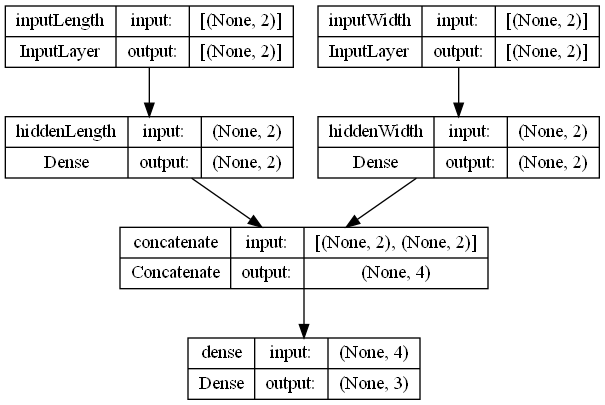

In [23]:
plot_model(model, show_shapes=True)

## 학습 시켜보기!

In [24]:
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=30,
                   verbose=1,
                   restore_best_weights=True)

In [30]:
model.fit([tr_x_l, tr_x_w], train_y, validation_split=0.15,
          epochs=1000, verbose=1, callbacks=[es])

Epoch 1/1000
4/4 [==============================] - 2s 177ms/step - loss: 1.6432 - accuracy: 0.2647 - val_loss: 1.7468 - val_accuracy: 0.3333
Epoch 2/1000
4/4 [==============================] - 0s 25ms/step - loss: 1.6196 - accuracy: 0.2843 - val_loss: 1.7237 - val_accuracy: 0.3333
Epoch 3/1000
4/4 [==============================] - 0s 29ms/step - loss: 1.5986 - accuracy: 0.2843 - val_loss: 1.7028 - val_accuracy: 0.3333
Epoch 4/1000
4/4 [==============================] - 0s 85ms/step - loss: 1.5784 - accuracy: 0.2843 - val_loss: 1.6814 - val_accuracy: 0.3333
Epoch 5/1000
4/4 [==============================] - 0s 41ms/step - loss: 1.5593 - accuracy: 0.2843 - val_loss: 1.6596 - val_accuracy: 0.3333
Epoch 6/1000
4/4 [==============================] - 0s 30ms/step - loss: 1.5389 - accuracy: 0.2941 - val_loss: 1.6382 - val_accuracy: 0.3333
Epoch 7/1000
4/4 [==============================] - 0s 24ms/step - loss: 1.5217 - accuracy: 0.2941 - val_loss: 1.6174 - val_accuracy: 0.3333
Epoch 8/1000

---
---
---
---
---

# IRIS - Connection I practice

- 위의 코드를 **그대로** 따라서 코드 작성하기!

## 데이터 불러오기

- iris.feature_names를 이용하여 판다스 데이터 프레임 만들기!

In [25]:
iris = load_iris()

x = iris.data
y = iris.target

In [26]:
df_x = pd.DataFrame(x, columns=iris.feature_names)
df_x.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


## train set, test set 구분하기

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
train_x, test_x, train_y, test_y = train_test_split(df_x, y, test_size=0.2, random_state=2023)

In [29]:
train_x.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,120.000000,120.000000,120.000000,120.000000
mean,5.847500,3.052500,3.828333,1.236667
std,0.812607,0.422072,1.740240,0.767834
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.450000,1.400000
75%,6.400000,3.325000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [30]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((120, 4), (120,), (30, 4), (30,))

## **length끼리, width끼리**

In [50]:
train_x.columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')

In [51]:
train_x.shape

(120, 4)

In [31]:
df_x.columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')

In [32]:
train_x_length = train_x.loc[: , ['sepal length (cm)', 'petal length (cm)']]
train_x_width = train_x.loc[: , ['sepal width (cm)', 'petal width (cm)']]

In [33]:
train_x_length.shape, train_x_width.shape

((120, 2), (120, 2))

In [34]:
train_x_length.head()

,sepal length (cm),petal length (cm)
9,4.9,1.5
38,4.4,1.3
18,5.7,1.7
119,6.0,5.0
98,5.1,3.0


In [35]:
train_x_width.head()

,sepal width (cm),petal width (cm)
9,3.1,0.1
38,3.0,0.2
18,3.8,0.3
119,2.2,1.5
98,2.5,1.1


In [36]:
train_x_length, train_x_width = np.array(train_x_length), np.array(train_x_width)

In [37]:
test_x_length = test_x.loc[: , ['sepal length (cm)', 'petal length (cm)']]
test_x_width = test_x.loc[: , ['sepal width (cm)', 'petal width (cm)']]

## One-hot Encoding

In [38]:
## one hot encoding
from tensorflow.keras.utils import to_categorical

In [39]:
class_n = len(np.unique(train_y)) # train_y가 예측값이지? 

In [40]:
train_y = to_categorical(train_y, class_n)
test__y = to_categorical(test_y, class_n)

In [41]:
train_y.shape # 하나였던 feature가 3개가 됨

(120, 3)

## Modeling : multi-input & Concatenate layer

In [42]:
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.activations import relu, softmax

from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [48]:
## Functional API
# 1. 세션 클리어
clear_session()

# 2. 사슬처럼 레이어 엮기 : input 2개
il_length = Input( shape=(2, ), name='inputLength')
hl_length = Dense(2, activation = 'relu', name = 'hiddenLength')(il_length)

il_width = Input( shape=(2,), name = 'inputWidth')
hl_width = Dense(2, activation = 'relu', name = 'hiddenWidth')(il_width)

cl = Concatenate()([hl_length, hl_width])
ol = Dense(3, activation = 'softmax')(cl)

# 3. 처음과 끝 모델 지정
model = Model([il_length, il_width], ol)
# 4. 모델 컴파일
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], 
              optimizer='adam')

# 양념
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputLength (InputLayer)       [(None, 2)]          0           []                               
                                                                                                  
 inputWidth (InputLayer)        [(None, 2)]          0           []                               
                                                                                                  
 hiddenLength (Dense)           (None, 2)            6           ['inputLength[0][0]']            
                                                                                                  
 hiddenWidth (Dense)            (None, 2)            6           ['inputWidth[0][0]']             
                                                                                              

## 모델 시각화

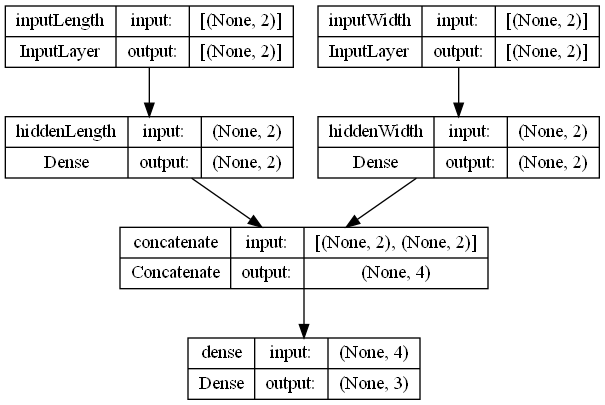

In [49]:
plot_model(model, show_shapes=True)

- 2째줄에 양옆으로 2개가 히든레이어 2개가 있다는 건데 이게 없으면 input에 노드 4개 놓고 연결한 거나 다를 게 없음

## 학습 시켜보기!

In [54]:
es = EarlyStopping(monitor='val_loss',
                   min_delta = 0,
                   patience = 5,
                   verbose = 1,
                   restore_best_weights = True)

In [58]:
# model.fit([train_x_length, train_x_width], train_y, validation_data=0.15,
          # epochs = 1000, verbose = 1, callbacks=[es])
model.fit([tr_x_l, tr_x_w], train_y, validation_split=0.15,
          epochs=1000, verbose=1, callbacks=[es])

Epoch 1/1000
4/4 [==============================] - 1s 155ms/step - loss: 1.4080 - accuracy: 0.5784 - val_loss: 1.5243 - val_accuracy: 0.4444
Epoch 2/1000
4/4 [==============================] - 0s 22ms/step - loss: 1.3979 - accuracy: 0.5784 - val_loss: 1.5123 - val_accuracy: 0.4444
Epoch 3/1000
4/4 [==============================] - 0s 22ms/step - loss: 1.3884 - accuracy: 0.5882 - val_loss: 1.5006 - val_accuracy: 0.4444
Epoch 4/1000
4/4 [==============================] - 0s 28ms/step - loss: 1.3780 - accuracy: 0.5980 - val_loss: 1.4896 - val_accuracy: 0.5000
Epoch 5/1000
4/4 [==============================] - 0s 22ms/step - loss: 1.3688 - accuracy: 0.6078 - val_loss: 1.4775 - val_accuracy: 0.5000
Epoch 6/1000
4/4 [==============================] - 0s 27ms/step - loss: 1.3588 - accuracy: 0.6078 - val_loss: 1.4654 - val_accuracy: 0.5000
Epoch 7/1000
4/4 [==============================] - 0s 35ms/step - loss: 1.3488 - accuracy: 0.5882 - val_loss: 1.4536 - val_accuracy: 0.5556
Epoch 8/1000

In [77]:
y_pred = model.predict(test_y)


ValueError: in user code:

    File "c:\ProgramData\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\ProgramData\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\ProgramData\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\ProgramData\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\ProgramData\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\ProgramData\anaconda3\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 216, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None,) dtype=int32>]


In [78]:
y_pred[:5]

NameError: name 'y_pred' is not defined

In [76]:
test_y[:5]

array([2, 1, 1, 2, 1])